# Using Monte Carlo Simulations to Model Lunar Craters from Impacting Asteroids

# Introduction
The properties of lunar craters can provide insight into planetary formation, surface dating, and the properties of their incident projectiles (Ivanov et al. 2002). Notably, crater chronometry systems such as isochrons have been particularly useful in dating geological surfaces with size frequency distributions (SFD) of meteor diameters on Mars and the Moon (Hartmann 1999; Williams et al. 2014). 

In this work, we will model the size frequency distribution of lunar craters using Monte Carlo simulations and known asteroid SFDs. We draw upon research from other authors to understand lunar crater SFD (Cross 1966; Ivanov et al. 2002; Wilhelms et al. 1978), impact crater scaling laws based on asteroid properties (Holsapple 1987; Schmidt 1980; Wheeler & Mathias 2019), and apply Monte Carlo simulations to asteroids (Williams et al. 2014). We aim to derive results consistent with the lunar production function and modern crater catalogs. In particular, we will compare our simulated SFDs against a comprehensive lunar database (Robbins 2018), which leverages a nearly global, ≥1-km crater database to reconcile differences between the Hartmann and Neukum chronologies in the critical 0.5-50 km range (Robbins 2018). 

# Methods

### Creating an Asteroid Size Frequency Distribution
Since we aimed to model a lunar crater size-frequency distribution (SFD) based on impacting asteroids, we had to find an appropriate SFD for impacting asteroids. We first constructed a theoretical asteroid relative size frequency distribution using a published polynomial fit from a study by Ivanov et al. (2002) that applies asteroids whose diamaters range from 0.01 km to 27 km:

$\log_{10}(R) = a_0 + \sum_{n=1}^{14} a_n \left[ \log_{10}(D) \right]$ 

In this equation, D is diameter, and R is the unitless value that hols the relative number of asteroids at a given diameter. The coefficients for this polynomial fit can be found from the same study (2002; Table 1). Since we are working with a large range of diameters, we created logspace of diameters range from 0.1 to 27 km. Then, we created a list of coefficients based on Table 1 from the study by Ivanov et al. (2002). We then used `r_plot_prediction` to generate a relative size frequency distribution for each corresponding diameter size from the equation above.

In [3]:
# plot data of diameter against asteroid counta

import matplotlib.pyplot as plt


# create initial lists
bin_count = 1000
min_diameter = 0.1
max_diameter = 27
diameter_list = np.logspace(np.log10(min_diameter), np.log10(max_diameter), num=bin_count )
coefficient_list = [0,1.375, 0.1272, -1.2821, -0.3075, 0.4148, 0.1911, -0.04261, -3.1802e-3, 2.799e-3, 6.892e-4, 2.614e-6, -1.416e-6, -1.191e-6]

# get the list of relative plots
r_list = r_plot_prediction(diameter_list=diameter_list, coefficient_list=coefficient_list)


While a normal size frequency distribution of asteroid diameters would inform us of the number of asteroids at a given size, a relative size frequency distribution is defined as follows (Ivanov et al. 2002): 

$R = D^3 \frac{dN}{dD}$

We can rearrange this equation to find $dN$, which gives us the number of asteroids in each bin of diameters:


$dN = R D^{-3} dD$

After calculating the number asteroids for each range of diameters $dN(D)$, we can plot the asteroid size frequency distribution using a bar plot (bin size = 1000) in a log-log scale with the code section below.

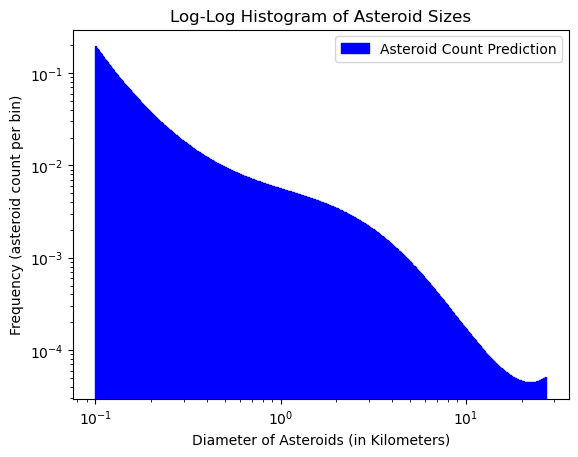

In [4]:
diff_diameter = np.diff(diameter_list)
diameter_list, r_list = diameter_list[:-1], r_list[:-1]

asteroid_count_list = r_list * diff_diameter * (diameter_list ** -3)

plt.bar(diameter_list, asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
        align='edge', edgecolor='b', color='blue', label='Asteroid Count Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Frequency (asteroid count per bin)")
plt.title("Log-Log Histogram of Asteroid Sizes")
plt.legend()
plt.show()

We can then convert our size frequency distribution of asteroid sizes to a probability distribution function by normalizing $dN(D)$. We can use this later to generate a population of asteroid frequency based on asteroid diameter. We can verify that this probability distribution function is accurate by summing the values. (Note: due to float precision issues in Python, the sum of the probability distribution will not exactly be 1.) As we can see below, our probability distribution function is now `normalized_asteroid_count_list`.

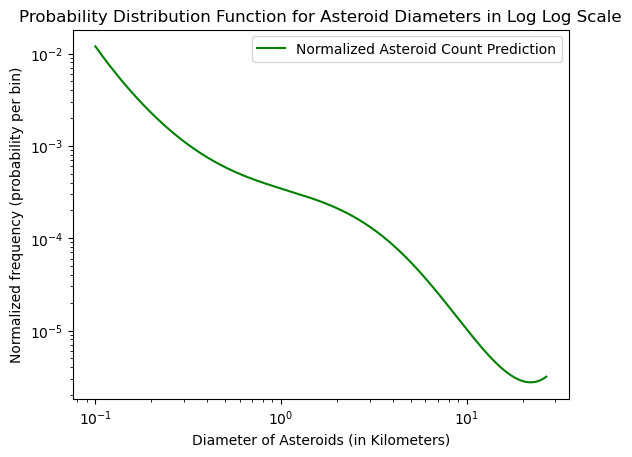

The sum of the probabilty distribution is 0.9999999999999972


In [8]:
normalized_asteroid_count_list = asteroid_count_list / sum(asteroid_count_list)

from matplotlib import pyplot as plt
# plt.bar(diameter_list, normalized_asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
#         align='edge', edgecolor='k', color='skyblue', alpha=0.01, label='Asteroid Count Prediction')
plt.plot(diameter_list, normalized_asteroid_count_list, label='Normalized Asteroid Count Prediction', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Normalized frequency (probability per bin)")
plt.title("Probability Distribution Function for Asteroid Diameters in Log Log Scale")
plt.legend()
plt.show()

print("The sum of the probabilty distribution is", sum(normalized_asteroid_count_list))

### Characterizing Asteroid Mass and Volume
Since we will need kinetic energy to characterize crater size based on asteroid impact, we will need to determine asteroid mass and volume. In our modelling, we made two core assumptions. The first assumption we made was that all of our asteroids were spherical, which helped us uniformly calculate the volumes of our asteroids. The second assumption came from the Ivanov et al. (2002) study, which made a similar assumption that asteroids have a constant density: $\rho_{\text{imp}}= 2.7 \frac{g}{cm^3}$. Diameters are converted to volumes using the usual spherical volume formula as outlined in **calculate_volume()**, and then to masses by multiplying by the density (as shown in **calculate_mass**). 

For example, we calculate asteroid volume and mass using the sample asteroid list from before:

In [7]:
volume_list = calculate_volume(diameter_list)
mass_list = calculate_mass(volume_list)

### Characterizing Asteroid Velocities and Kinetic Energy
To determine the lunar crater size from asteroid impact, calculating the kinetic energy for impacting asteroids was critical. First, we needed a probabilistic model for asteroid velocites. We assumed that the distribution of asteroid velocities would follow a poisson distribution

Monte Carlo Simulations

In [2]:
import numpy as np
from random import choices
from matplotlib import pyplot as plt
import pandas as pd
import math

RUNS = 1000
POPULATION_SIZE = 10000

# -----CONSTANTS------
MU_REGOLITH = 0.41  # μ from Holsapple paper's value for lunar regolith (dimensionless)
RHO_IMP_G_CM3 = 2.7  # impactor density [g/cm^3]
RHO_IMP_KG_M3 = (
    RHO_IMP_G_CM3 * 1000.0
)  # converted to kg/m^3 (2.7 g/cm^3 -> 2700 kg/m^3)
MEAN_IMPACT_VEL_KM_S = 17.0  # Mean impact velocity [km/s] (From Yue et al. (2013))
MEAN_IMPACT_VEL_M_S = MEAN_IMPACT_VEL_KM_S * 1000.0  # [m/s]
N_MONTE_CARLO = RUNS * POPULATION_SIZE  # monte carlo run number (count)
VEL_EXPONENT = 0.44  # exponent used for velocity scaling (dimensionless)
CRATER_TO_PROJECTILE_RATIO = (
    10.0  # crater diameter / projectile diameter (dimensionless)
)
MAX_DIAMETER = 300  # maximum crater diameter filter [km] — note: earlier comment mentioned 300 km which is inconsistent with this value


def r_plot_prediction(diameter_list, coefficient_list):
    # expects a list of diameters in km and outputs coefficient ount
    asteroid_count_list = []
    for d in diameter_list:
        log_d = np.log10(d)
        log_n = 0
        for i, coeff in enumerate(coefficient_list):
            log_n += coeff * (log_d**i)
        n = 10**log_n
        asteroid_count_list.append(n)
    return asteroid_count_list


def generate_asteroid_population(diameter_list, normalized_asteroid_list, k=100):
    new_population = choices(diameter_list, weights=normalized_asteroid_list, k=k)
    return new_population


def calculate_volume(simulated_asteroid_diameters_list):
    # Input: simulated_asteroid_diameters_list elements are diameters in [km]
    # Output: list of volumes in [km^3] computed assuming spherical asteroids
    volume_list = []
    for d in simulated_asteroid_diameters_list:
        r = d / 2
        volume = (4 / 3) * np.pi * (r**3)
        volume_list.append(volume)
    return volume_list


def calculate_mass(volume_list):
    # Assumes input volume_list elements are in [km^3].
    # density is intended to be the impactor density in [kg/km^3].
    # NOTE: If RHO_IMP_G_CM3 = 2.7 g/cm^3 -> 2700 kg/m^3 -> 2700 * 1e9 = 2.7e12 kg/km^3.
    # The value 2.7e9 here is likely incorrect relative to RHO_IMP_G_CM3; check unit conversion.
    density = 2.7e12  # kg/km^3  (EXPECTED ~2.7e12 kg/km^3 if using 2.7 g/cm^3)
    mass_list = []
    for volume in volume_list:
        # mass in [kg] if density is [kg/km^3] and volume is [km^3]
        mass = density * volume
        mass_list.append(mass)
    return mass_list


def monte_carlo_crater(diameter_list, normalized_asteroid_count_list, runs=1000, k=100):
    # Returns a list (length = runs) of lists of selected diameters.
    # The diameters in the returned lists have the same units as `diameter_list` (expected [km]).
    crater_diameter_list = []
    for _ in range(runs):
        # get average volume, and diameters
        simulated_asteroid_diameters_list = generate_asteroid_population(
            diameter_list, normalized_asteroid_count_list, k
        )
        crater_diameter_list.append(simulated_asteroid_diameters_list)

    return crater_diameter_list


def monte_carlo_simulation(
    diameter_list, normalized_asteroid_count_list, runs=1000, k=100
):
    # Returns:
    #   total_mass_list : list of lists of masses [kg] (if calculate_mass's density units are correct)
    #   total_diameter_list : list of lists of diameters [km] (same units as diameter_list)
    #   total_volume_list : list of lists of volumes [km^3]
    total_mass_list = []
    total_diameter_list = []
    total_volume_list = []
    for _ in range(runs):
        # get average volume, and diameters
        simulated_asteroid_diameters_list = generate_asteroid_population(
            diameter_list, normalized_asteroid_count_list, k
        )
        volume_list = calculate_volume(simulated_asteroid_diameters_list)
        mass_list = calculate_mass(volume_list)

        total_mass_list.append(mass_list)
        total_diameter_list.append(simulated_asteroid_diameters_list)
        total_volume_list.append(volume_list)

    return total_mass_list, total_diameter_list, total_volume_list


def create_log_histogram(data, title, xlabel, ax):
    # Filter for positive values, as log scale cannot handle non-positives
    data_positive = data[data > 0]

    if len(data_positive) == 0:
        ax.set_title(title)
        ax.text(
            0.5, 0.5, "No positive data to plot.", transform=ax.transAxes, ha="center"
        )
        return

    # Determine the range in log space
    min_val = data_positive.min()
    max_val = data_positive.max()

    # Create logarithmically spaced bins (100 bins for resolution)
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

    # Plot the histogram
    # Density=False plots the raw count (frequency)
    ax.hist(data_positive, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)

    # Set log scale for x-axis
    ax.set_xscale("log")

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency (Count)")
    ax.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.6)


# ------ FUNCTIONS ----------
def load_crater_catalog(csv_path: str) -> pd.DataFrame:
    """
    Get the whole database's worth of crater diameters.
    Notes on units:
      - DIAM_CIRC_IMG is assumed to be in [km] (this code treats it as km).
      - D_final_m is created in [m] (km * 1000).
    """
    df = pd.read_csv(csv_path)
    df = df.copy()

    # filter craters less than MAX_DIAMETER km (DEFAULT = 35 km)
    # NOTE: previous comment said "300 kilometers" which is inconsistent with MAX_DIAMETER = 35
    df = df[df["DIAM_CIRC_IMG"] < MAX_DIAMETER]

    df["D_final_m"] = df["DIAM_CIRC_IMG"] * 1000.0  # convert [km] -> [m]
    return df


def get_simple_craters(df: pd.DataFrame, simple_limit_km: float = 100) -> pd.DataFrame:
    """
    Filter the crater database down to simple craters.
    Note:
      - The docstring says "10 km or less", but the default parameter is 10000.
      - This is likely a bug: a sensible default for `simple_limit_km` would be 10.0 (km).
    Args:
      df: DataFrame with DIAM_CIRC_IMG in [km].
      simple_limit_km: threshold in [km] (default currently 10000 — check intended value).
    """
    mask = df["DIAM_CIRC_IMG"] <= simple_limit_km
    return df[mask].copy()


def sample_impact_velocities_poisson(
    n_samples: int,
    mean_velocity_km_s: float = MEAN_IMPACT_VEL_KM_S,
    random_state: int | None = None,
):
    """
    Sample impact velocities from a Poisson distribution with mean
    `mean_velocity_km_s` (in km/s), then convert to m/s.
    Returns:
      velocity array in [m/s]
    """
    rng = np.random.default_rng(random_state)
    v_km_s = rng.poisson(lam=mean_velocity_km_s, size=n_samples).astype(float)
    # avoid zero velocities from Poisson draw
    v_km_s[v_km_s == 0] = 1e-3
    return v_km_s * 1000  # [m/s]


def calculate_kinetic_energy(mass_population: np.ndarray, velocity_samples: np.ndarray):
    """
    Calculate kinetic energy for each mass and velocity combination.
    KE (Joules) = 0.5 * m[kg] * v[m/s]^2
    This function multiplies by 1e7 to convert Joules -> ergs:
      1 J = 1e7 erg
    Returns:
      KE_array_ergs : energy in [erg]
    Note: Ensure mass_population is in [kg] and velocity_samples in [m/s] before calling.
    """

    KE_array = 0.5 * mass_population * (velocity_samples**2)
    KE_array_ergs = KE_array * (1e7)
    return KE_array_ergs


def calculate_crater_diameters(energy_population: np.ndarray):
    """
    Convert an energy population into crater diameters.
    Notes on units/assumptions:
      - `energy_population` is expected to be in units compatible with the empirical constant K.
        In the code below, K and the "/100" conversion imply V_array is computed in [cm^3],
        so energy_population is likely expected in [erg] (check original source).
      - V_array is treated as a volume in [cm^3]; the cubic root yields a length in [cm],
        and dividing by 100 converts [cm] -> [m], so D_array is returned in [m].
    Returns:
      D_array : crater diameters in [m]
    """
    K = 0.00319
    alpha = 0.726
    V_array = K * (energy_population ** (alpha))
    D_array = (2 * np.cbrt(((3 * V_array) / (4 * math.pi)))) / 100  # convert cm -> m
    print(D_array.flatten())
    return D_array


def calculate_crater_diameters_v2(
    energy_population: np.ndarray, mass_population: np.ndarray
):
    """
    Empirical conversion from energy (and mass) to crater diameter.
    Units and important notes:
      - energy_population is expected to be in [erg] (consistent with calculate_kinetic_energy).
      - mass_population: check units. The exponent on mass (0.136) and the use of densities
        in [g/cm^3] suggests the original formula may have expected mass in [g], not [kg].
        Passing masses in [kg] without converting to [g] will change results.
      - g is set to 162 with a comment 'm/s^2' but lunar surface gravity is ~1.62 m/s^2.
        162 may come from using cm/s^2 (1.62 m/s^2 = 162 cm/s^2). Confirm the intended units.
      - moon_density and impactor_density are in [g/cm^3].
      - The formula produces V_array in [cm^3] (based on later division by 100 to get m),
        so D_array returned below is in [m].
    Returns:
      D_array : crater diameters in [m]
    """
    g = 162  # NOTE: value likely in [cm/s^2] (162 cm/s^2 = 1.62 m/s^2)
    moon_density = 3.344  # g/cm^3
    impactor_density = 2.7  # g/cm^3

    V_array = (
        3.02
        * (energy_population**0.648)
        * (mass_population**0.136)
        * (g**-0.648)
        * (impactor_density**0.216)
        * (moon_density**-1)
    )  # Energy measured in ergs, and mass measured in KG
    D_array = (2 * np.cbrt(((3 * V_array) / (4 * math.pi)))) / 100  # convert cm -> m
    return D_array


def monte_carlo_crater_population(
    n_runs: int, mass_population: np.ndarray, random_state: int | None = None
):
    """
    Monte Carlo pipeline:

    1. Estimate projectile masses from the observed simple crater diameters,
       assuming a fixed crater-to-projectile ratio and spherical impactors.
    2. Calibrate the scaling law on a representative crater size.
    3. Sample masses from the mass population and velocities from a
       Poisson distribution.
    4. Convert (m, v) into crater diameters using the scaling law.
    """

    # Monte Carlo sampling
    velocity_samples = sample_impact_velocities_poisson(
        n_samples=n_runs,
        random_state=random_state,
    )

    kinetic_energy_ergs = calculate_kinetic_energy(
        mass_population=mass_population, velocity_samples=velocity_samples
    )
    D_sim_m = calculate_crater_diameters_v2(
        energy_population=kinetic_energy_ergs,
        mass_population=np.asarray(mass_population),
    )

    # Returned dictionary units:
    #   mass_samples_kg    -> list of masses as provided (expected [kg], but check upstream)
    #   velocity_samples_m_s -> velocities in [m/s]
    #   crater_diameters_m  -> simulated crater diameters in [m]
    return {
        "mass_samples_kg": mass_population,
        "velocity_samples_m_s": velocity_samples,
        "crater_diameters_m": D_sim_m,
    }


def compute_cumulative_sfd(D_m: np.ndarray):
    """
    Compute a cumulative size–frequency distribution N(>D) from
    an array of crater diameters D_m [m].

    Returns:
        D_sorted_m : diameters sorted ascending
        N_gt       : cumulative counts N(>D) for each D_sorted_m
    """
    D_sorted = np.sort(np.asarray(D_m, dtype=float))
    N = np.arange(D_sorted.size, 0, -1)  # N, N-1, ..., 1
    N_total = D_sorted.size

    # N = N_total, N_total-1, ..., 1 (Cumulative counts N(>=D))
    N_gt = np.arange(N_total, 0, -1)

    # F = N / N_total (Normalized cumulative frequency F(>=D))
    F_gt = N_gt / N_total
    return D_sorted, N_gt, F_gt


def plot_sfd_overlay(
    D_obs_m: np.ndarray,
    D_sim_m: np.ndarray,
    title: str = "Lunar Simple Crater SFD: Observed vs Monte Carlo",
):
    """
    Plot cumulative SFDs for observed and simulated craters on a log plot.
    """
    D_obs_sorted_m, N_obs, normalized_N_obs = compute_cumulative_sfd(D_obs_m)
    D_sim_sorted_m, N_sim, normalized_N_sim = compute_cumulative_sfd(D_sim_m)

    # Convert to km for plotting
    D_obs_km = D_obs_sorted_m / 1000.0
    D_sim_km = D_sim_sorted_m / 1000.0

    plt.figure(figsize=(7, 5))
    plt.loglog(D_obs_km, normalized_N_obs, label="Robbins 2019 simple craters")
    plt.loglog(D_sim_km, normalized_N_sim, label="Monte Carlo model", linestyle="--")

    plt.xlabel("Crater diameter D [km]")
    plt.ylabel("Cumulative N(>D)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()


def plot_sfd_overlay_v2(
    D_datasets: list[np.ndarray],
    labels: list[str],
    D_min_km: float = 1.0,
    title: str = "Cumulative SFD Comparison",
):
    """
    Plot cumulative SFDs for multiple observed and simulated crater datasets
    on a log plot, normalized to the population with D >= D_min_km.

    Args:
        D_datasets (list[np.ndarray]): A list of 1D arrays, where each array
                                        contains crater diameters (in meters)
                                        for one population.
        labels (list[str]): A list of string labels corresponding to each dataset.
        D_min_km (float): The minimum diameter (in km) to include for
                          normalization and comparison. Defaults to 1.0 km.
    """
    if len(D_datasets) != len(labels):
        raise ValueError("The number of datasets must match the number of labels.")

    D_min_m = D_min_km * 1000.0

    plt.figure(figsize=(8, 6))

    D_max_m = MAX_DIAMETER  # 20 km in meters

    # Define a set of line styles/colors for differentiation
    line_styles = ["-", "--", ":", "-."]

    for i, D_m in enumerate(D_datasets):

        # 1. Filter the data to the comparison window (D >= D_min_m)
        D_filtered = D_m[D_m >= D_min_m]

        # 2. Get sorted diameters and normalized frequencies F'(>=D)
        # We need a function similar to the 'compute_comparison_sfd' discussed earlier.
        # For simplicity here, we'll implement the comparison logic directly.
        D_sorted = np.sort(D_filtered)
        N_total_filtered = D_sorted.size

        if N_total_filtered == 0:
            print(
                f"Warning: Dataset '{labels[i]}' has no craters >= {D_min_km} km. Skipping."
            )
            continue

        # Cumulative frequency calculation F'(>=D)
        N_gt = np.arange(N_total_filtered, 0, -1)
        normalized_N_fraction = N_gt / N_total_filtered

        # Convert to km for plotting
        D_km = D_sorted / 1000.0

        # Plotting the normalized cumulative frequency
        plt.loglog(
            D_km,
            normalized_N_fraction,
            label=labels[i],
            linestyle=line_styles[i % len(line_styles)],  # Cycle through line styles
            linewidth=2,
        )

    # 1. FIXED Y-AXIS  (No LaTeX)
    plt.ylabel("Normalized Cumulative Frequency F'(>= D)")

    # 2. FIXED X-AXIS LABEL (No LaTeX, using f-string for D_min_km)
    plt.xlabel(
        f"Crater diameter D [km] (Comparison range: >= {D_min_km} km & <= {MAX_DIAMETER} km)"
    )

    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")

    # This should now execute without the Matplotlib ParseFatalException
    plt.tight_layout()
    plt.show()
